In [1]:
import os
import sys
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm


In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

In [3]:
# from models.RNN import SimpleRNN
from utils.utils import count_parameters, mse_per_timestep
from utils.train import train_and_validate, evaluate_model, train
from utils.watertopo import WaterTopo

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Is CUDA enabled? False
Number of GPUs 0
Using device: cpu


In [5]:
# loading the data
tra_datapath = str(root)+"/data/normalized_data/tra_val"
test_datapath = str(root)+"/data/normalized_data/test1"
grid_size = 64
sim_amount = 80
test_amount = 20

# select one simulation for training
sims = WaterTopo.load_simulations(save_folder = tra_datapath,
                                  sim_amount = sim_amount,
                                  number_grids = grid_size)

test = WaterTopo.load_simulations(save_folder=test_datapath,
                                  sim_amount = test_amount,
                                  number_grids = grid_size)



### Process all the simulations for training and validation

In [6]:
def dataprocessing(data, sim_amount, timestep, gridsize):
    '''
    # Reshape the data into into the 2D array with
    # each row representing the pixels (each pixel is regarded as a new variable)
    # each column representing the timestep (condider the temporal features as the other dimension of images)
    '''
    dem = np.zeros((sim_amount,timestep,gridsize,gridsize))
    wd = np.zeros((sim_amount,timestep,gridsize,gridsize))
    wl = np.zeros((sim_amount,timestep,gridsize,gridsize))

    for i in range(sim_amount):
        wd[i] =  data[i].wd
        dem[i] = data[i].topography
        wl[i] = wd[i] + dem[i]

    def dataconvert(meshdata,timestep,gridsize):
        tempCNN_array = np.zeros((gridsize*gridsize,timestep))
        for i in range(timestep):
            tempCNN_array[:,i] = meshdata[i].reshape(-1)
        return tempCNN_array

    dem_new = []
    wd_new = []
    wl_new = []

    for i in range(sim_amount):
        dem_new.append(dataconvert(dem[i],timestep,gridsize))
        wd_new.append(dataconvert(wd[i],timestep,gridsize))
        wl_new.append(dataconvert(wl[i],timestep,gridsize))

    return dem_new, wd_new, wl_new

In [7]:
timestep = len(sims[0].wd)

# Training data
dem_new, wd_new, wl_new = dataprocessing(sims, sim_amount = sim_amount, timestep = timestep, gridsize= grid_size)

# Testing data
dem_test, wd_test, wl_test = dataprocessing(test, sim_amount = test_amount, timestep = timestep, gridsize= grid_size)


### Process the testing data

### Split the data

In [8]:
dem_tra, dem_val, wd_tra, wd_val, wl_tra, wl_val, ix_tra, ix_tst = train_test_split(
    dem_new, wd_new, wl_new, np.arange(sim_amount), test_size=0.30, shuffle=True, random_state=42)

### Create the input for the model by combining dem and water depth and the output 

In [9]:
train_inputs = np.stack((dem_tra, wd_tra),1)
train_outputs = np.array(wl_tra)[:,None]

val_inputs = np.stack((dem_val, wd_val),1)
val_outputs = np.array(wl_val)[:,None]

test_inputs = np.stack((dem_test, wd_test),1)
test_outputs = np.array(wl_test)[:,None]

In [10]:
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float32), torch.tensor(train_outputs, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float32), torch.tensor(val_outputs, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float32), torch.tensor(test_outputs, dtype=torch.float32 ))

### Use the Unet Encoder-Decoder CNN to train the model  

In [11]:
# class CNNBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
#         super().__init__()

#         layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
#         if batch_norm:
#             layers.append(nn.BatchNorm2d(num_features=out_channels))
#         layers.append(nn.PReLU())
#         layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))

#         self.cnnblock = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.cnnblock(x)

# class Encoder(nn.Module):
#     def __init__(self, channels=[4, 8, 16], kernel_size=3, padding=1, bias=False, batch_norm=True):
#         super().__init__()

#         self.enc_blocks = nn.ModuleList([
#             CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
#                      batch_norm=batch_norm)
#             for block in range(len(channels)-1)]
#             )
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

#     def forward(self, x):
#         outs = []
#         for block in self.enc_blocks:
#             x = block(x)
#             outs.append(x)
#             x = self.pool(x)
#         return outs

# class Decoder(nn.Module):
#     def __init__(self, channels=[16, 8, 4], kernel_size=3, padding=1, bias=False, batch_norm=True):
#         super().__init__()
#         self.channels = channels
#         self.upconvs = nn.ModuleList([
#             nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=1)
#             for block in range(len(channels)-1)]
#             )
#         self.dec_blocks = nn.ModuleList([
#             CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
#                      batch_norm=batch_norm)
#              for block in range(len(channels)-1)]
#              )

#     def forward(self, x, x_skips):
#         for i in range(len(x_skips)):
#             x = self.upconvs[i](x)
#             x = torch.cat((x, x_skips[-(1+i)]), dim=1)
#             x = self.dec_blocks[i](x)

#         x = self.dec_blocks[-1](x)
#         return x

# class CNN(nn.Module):
#     def __init__(self, node_features, out_dim=1, n_downsamples=3, initial_hid_dim=64, batch_norm=True,
#                  bias=True):
#         super(CNN, self).__init__()
#         hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
#         encoder_channels = [node_features]+hidden_channels
#         decoder_channels = list(reversed(hidden_channels))+[out_dim]

#         self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1,
#                                bias=bias, batch_norm=batch_norm)
#         self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1,
#                                bias=bias, batch_norm=batch_norm)

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x[-1], x[:-1])
#         x = nn.Sigmoid()(x)
#         return x

In [12]:
from models.TempUnet import CNN
node_features = 2 # Water Depth and DEM
model = CNN(node_features=node_features,
            n_downsamples=3,
            initial_hid_dim=2,
            batch_norm=True, bias=True)

print(f"CNN --> num. trainable parameters:{count_parameters(model):8d}")

CNN --> num. trainable parameters:    1984


In [13]:
# display(model)

### Define the training parameter, the optimizer, and the dataloader

In [14]:
# Set training parameters
learning_rate = 0.0005
batch_size = 16
num_epochs = 150
device = 'cpu'
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
model_name = 'TempCNN(VX,VY)'
save_path = "../results/trained_models/" + model_name
# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training and Validating 

In [15]:
# train_losses, val_losses, best_val_loss, time = train_and_validate(
#                                                                    model = model,
#                                                                    train_loader = train_loader,
#                                                                    val_loader = val_loader,
#                                                                    criterion = criterion,
#                                                                    optimizer = optimizer,
#                                                                    num_epochs = num_epochs,
#                                                                    device = device,
#                                                                    save_path = save_path
#                                                                   )

In [16]:
# test_loss = evaluate_model(model, test_loader, criterion, device=device)
# print(test_loss)

### Visualisation of results

In [17]:
# plt.plot(train_losses, label='Training')
# plt.plot(val_losses, label='Validation')
# plt.yscale('log')
# plt.title('Losses')
# plt.xlabel('Epochs')
# plt.legend()
# plt.savefig("TempCNN Loss.png")
# plt.show()

### Load the Model 

In [18]:
# Load Model
saving_model_path = str(src) + "/results/trained_models/tempcnn/TempCNN"
model.load_state_dict(torch.load(saving_model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [19]:
# select one sample
data_id = -1 # simulaition number

x = test_dataset[data_id][0].unsqueeze(0)
WD= test_dataset[data_id][0][1]

# predict WL
pred_WL = model(x).detach()

demx = x.squeeze(0)[0].reshape(grid_size,grid_size,timestep).permute((2,0,1))
WD = WD.reshape(grid_size,grid_size,timestep).permute((2,0,1))

pred_WL = pred_WL.squeeze(0,1).reshape(grid_size,grid_size,timestep).permute((2,0,1))

pred_WD = pred_WL - demx

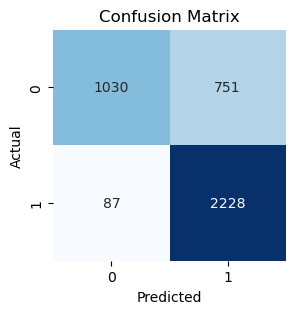

Confusion Matrix:
 [[1030  751]
 [  87 2228]]
Accuracy: 0.7954
Recall: 0.9624
Precision: 0.7479
F1 Score: 0.8417


In [20]:
from utils.performance import confusionmatrix
confusionmatrix(pred_WD,WD,-1)

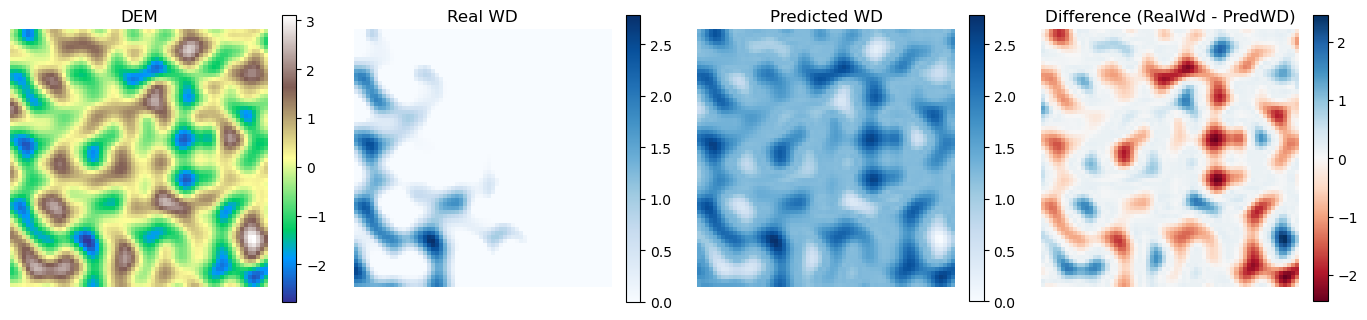

In [21]:
from matplotlib.colors import TwoSlopeNorm
t = 48

diff_WD = WD[t] - pred_WD[t]

fig, axs = plt.subplots(1, 4, figsize=(17,5))
max_FAT = max(pred_WD.max(), WD.max())
max_diff = max(diff_WD.max(), -diff_WD.min())

axs[0].imshow(demx[0], cmap='terrain', origin='lower')
axs[1].imshow(WD[t], cmap='Blues', origin='lower')
axs[2].imshow(pred_WD[t], cmap='Blues', origin='lower')
axs[3].imshow(diff_WD, cmap='RdBu', origin='lower')

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = demx.min(), vmax=demx.max()),
                            cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues'), fraction=0.05, shrink=0.9, ax=axs[1])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues'), fraction=0.05, shrink=0.9, ax=axs[2])
plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                            cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])
for ax in axs:
    ax.axis('off')

axs[0].set_title('DEM')
axs[1].set_title('Real WD')
axs[2].set_title('Predicted WD')
axs[3].set_title('Difference (RealWd - PredWD)')
# plt.savefig("TempCNN Prediction.png")
plt.show()

Selecting specific timestep


C:\Users\sagi8\Documents\GitHub\DS-AI\src\utils\performance.py:22: RuntimeWarning: divide by zero encountered in divide
  acc = 1-np.divide(abs((prediction[t] - Real[t])),Real[t])


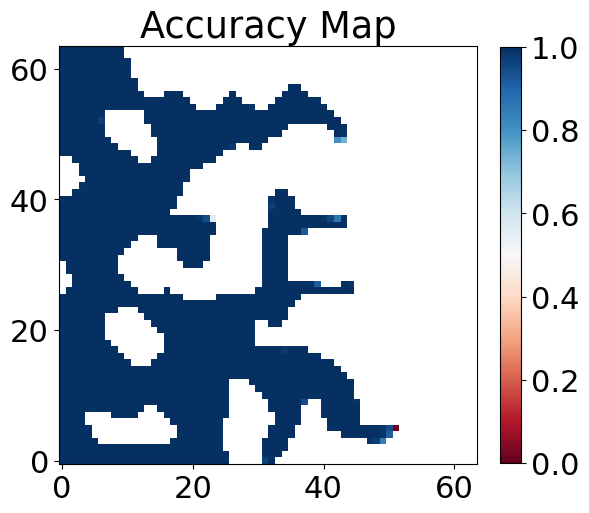

In [22]:
from utils.performance import performance
from matplotlib.animation import ArtistAnimation, PillowWriter

performance(pred_WD, WD, 'specific', timestep = 65)

In [23]:
# This cell is to generate the animation


# nx, ny = (64,64)
# x = np.linspace(0,6350, nx)
# y = np.linspace(0,6350, ny)
# xv, yv = np.meshgrid(x,y)
# from utils import flow_animation
# pred_WLt = np.array(pred_WL)
# path = str(src) + "/animations/Flooding AnimationTempCNN.gif"
# flow_animation.animation_create(
#                  savepath = path,
#                  X = xv,
#                  Y = yv,
#                  Z = test[data_id].topography,
#                  wd = pred_WLt,
#                  N = 64,
#                  fps = 10, color_dem = cm.gist_earth, mask_threshold = 0)

In [24]:

# This cell saves the averaged MSE for each timestep for 20 test simulations

model.eval()
model.load_state_dict(torch.load(str(src)+"/results/trained_models/Tempcnn/TempCNN"))

grid_size = 64
channels = 2
sim_length = 97

# Let's do a crude Monte Carlo with a single model, calculating the loss after each timestep
sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test1/", 20, grid_size, use_augmented_data=True)
mse = np.zeros(97)

for sim in sims:

   inputs = np.zeros((1, channels, grid_size, grid_size))
   targets = sim.wd


   # Select the time step where you want to start
   id = 0

   inputs[0, 0, :, :] = sim.topography
   inputs[0, 1, :, :] = sim.return_timestep(id)
   inputs = torch.tensor(inputs, dtype=torch.float32)

   targets = torch.tensor(targets, dtype=torch.float32)
   targets[0,:,:] = inputs[0,1,:,:]

   outputs = torch.zeros(targets.shape)
   outputs[0,:,:] = inputs[0,1,:,:]

   for t in range(1, sim_length):
      outputs[t,:,:] = model(inputs.to(device)).detach()
      inputs[0,1,:,:] = outputs[t,:,:]

   mse += mse_per_timestep(targets, outputs)

mse = mse / len(sims)

# np.savetxt(str(src)+"/results/error_accumulation/TempCNN", mse)